## Import packages

In [3]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import scipy as scipy
#import metpy as mtp
import math
from scipy import integrate
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [4]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [24]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

time_slice = slice('1980-01-01', '2021-12-31')

### Load instantaneous AHT calcs

In [25]:
aht_ds_6hrly = xr.open_dataset('../aht_time_series/era5_aht_time_series_full.nc').sel(time=time_slice)
aht_ds_6hrly

<xarray.Dataset>
Dimensions:                     (time: 61364, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1980-01-01 ... 2021-12-...
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 ...
    eddy_aht                    (time, latitude) float64 ...
    mmc_aht                     (time, latitude) float64 ...
    total_aht_no_seasons        (time, latitude) float64 ...
    eddy_aht_no_seasons         (time, latitude) float64 ...
    mmc_aht_no_seasons          (time, latitude) float64 ...
    ...                          ...
    total_aht_dry               (time, latitude) float64 ...
    eddy_aht_dry                (time, latitude) float64 ...
    mmc_aht_dry                 (time, latitude) float64 ...
    total_aht_no_seasons_dry    (time, latitude) float64 ...
    eddy_aht_no_seasons_dry     (time, latitude) float64 ...
    mmc_aht_no_seasons_dry      (time, latitude) float64 ...

### Load Aaron's AHT data

In [26]:
aht_ds_monthly = xr.open_dataset('../era5_data/era5_aht_ds_1979_2022.nc').sel(time=time_slice)

aht_ds_monthly

<xarray.Dataset>
Dimensions:            (time: 504, latitude: 361, level: 37)
Coordinates:
  * time               (time) datetime64[ns] 1980-01-31 ... 2021-12-31
  * level              (level) int64 1 2 3 5 7 10 ... 875 900 925 950 975 1000
  * latitude           (latitude) float64 90.0 89.5 89.0 ... -89.0 -89.5 -90.0
Data variables: (12/33)
    total_aht          (time, latitude) float64 ...
    total_aht_dry      (time, latitude) float64 ...
    total_aht_moist    (time, latitude) float64 ...
    total_aht_pot      (time, latitude) float64 ...
    total_aht_dry_pot  (time, latitude) float64 ...
    te_aht             (time, latitude) float64 ...
    ...                 ...
    eddy_aht_dry       (time, latitude) float64 ...
    eddy_aht_moist     (time, latitude) float64 ...
    eddy_aht_dry_pot   (time, latitude) float64 ...
    mass               (time, latitude) float64 ...
    mse_surf           (time, latitude) float64 ...
    strm_fnct          (time, level, latitude) float64 ...

### Get JJA and DJF 6-hrly data

In [27]:
aht_6hrly_jja = aht_ds_6hrly.sel(time=aht_ds_6hrly.time.dt.month.isin([6, 7, 8]))
aht_6hrly_djf = aht_ds_6hrly.sel(time=aht_ds_6hrly.time.dt.month.isin([1, 2, 12]))

### Make the plot

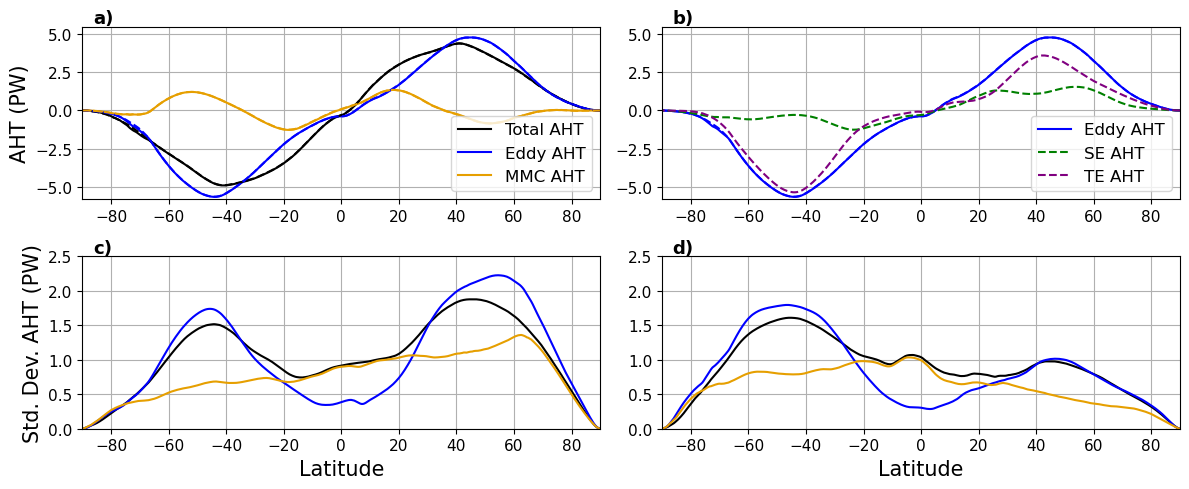

In [59]:
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(12, 5))

axs[0,0].plot(lats, aht_ds_6hrly.total_aht.mean(['time'])/ 1e15, color='k', label='Total AHT')
axs[0,0].plot(lats, aht_ds_6hrly.eddy_aht.mean(['time'])/ 1e15, color='b', label='Eddy AHT')
axs[0,0].plot(lats, aht_ds_6hrly.mmc_aht.mean(['time'])/ 1e15, color='#E69F00', label='MMC AHT')

axs[0,0].plot(lats, aht_ds_monthly.total_aht.mean(['time']) / 1e15, '--', color='k')
axs[0,0].plot(lats, (aht_ds_monthly.te_aht + aht_ds_monthly.se_aht).mean(['time']) / 1e15, '--', color='b')
axs[0,0].plot(lats, aht_ds_monthly.mmc_aht.mean(['time']) / 1e15, '--', color='#E69F00')

axs[0,1].plot(lats, aht_ds_6hrly.eddy_aht.mean(['time'])/ 1e15, color='b', label='Eddy AHT')
axs[0,1].plot(lats, (aht_ds_monthly.te_aht + aht_ds_monthly.se_aht).mean(['time']) / 1e15, '--', color='b')
axs[0,1].plot(lats, aht_ds_monthly.se_aht.mean(['time']) / 1e15, '--', color='g', label='SE AHT')
axs[0,1].plot(lats, aht_ds_monthly.te_aht.mean(['time']) / 1e15, '--', color='purple', label='TE AHT')

axs[0,0].legend(loc=4, fontsize=12)
axs[0,1].legend(loc=4, fontsize=12)

axs[1,0].plot(lats, aht_6hrly_djf.total_aht.std('time') / 1e15, color='k')
axs[1,0].plot(lats, aht_6hrly_djf.eddy_aht.std('time') / 1e15, color='b')
axs[1,0].plot(lats, aht_6hrly_djf.mmc_aht.std('time') / 1e15, color='#E69F00')

axs[1,1].plot(lats, aht_6hrly_jja.total_aht.std('time') / 1e15, color='k')
axs[1,1].plot(lats, aht_6hrly_jja.eddy_aht.std('time') / 1e15, color='b')
axs[1,1].plot(lats, aht_6hrly_jja.mmc_aht.std('time') / 1e15, color='#E69F00')

axs[0,0].tick_params(axis='both', which='major', labelsize=11)
axs[0,1].tick_params(axis='both', which='major', labelsize=11)
axs[1,0].tick_params(axis='both', which='major', labelsize=11)
axs[1,1].tick_params(axis='both', which='major', labelsize=11)

axs[0,0].grid()
axs[0,1].grid()
axs[1,0].grid()
axs[1,1].grid()

axs[0,0].set_xlim([-90, 90])
axs[0,1].set_xlim([-90, 90])
axs[1,0].set_xlim([-90, 90])
axs[1,1].set_xlim([-90, 90])

axs[0,0].set_ylim([-5.8, 5.5])
axs[0,1].set_ylim([-5.8, 5.5])
axs[1,0].set_ylim([0, 2.5])
axs[1,1].set_ylim([0, 2.5])

axs[0,0].text(x=0.02, y=1.02, s='a)', transform=axs[0,0].transAxes, fontsize=13, fontweight='bold')
axs[0,1].text(x=0.02, y=1.02, s='b)', transform=axs[0,1].transAxes, fontsize=13, fontweight='bold')
axs[1,0].text(x=0.02, y=1.02, s='c)', transform=axs[1,0].transAxes, fontsize=13, fontweight='bold')
axs[1,1].text(x=0.02, y=1.02, s='d)', transform=axs[1,1].transAxes, fontsize=13, fontweight='bold')

axs[0,0].set_ylabel('AHT (PW)', fontsize=15)
axs[1,0].set_ylabel('Std. Dev. AHT (PW)', fontsize=15)
axs[1,0].set_xlabel('Latitude', fontsize=15)
axs[1,1].set_xlabel('Latitude', fontsize=15)

fig.tight_layout()

#fig.savefig('figures/monthly_6_hrly_aht_comp')

plt.show()

In [70]:
aht_grad_djf = aht_6hrly_djf.differentiate('latitude')
aht_grad_jja = aht_6hrly_jja.differentiate('latitude')

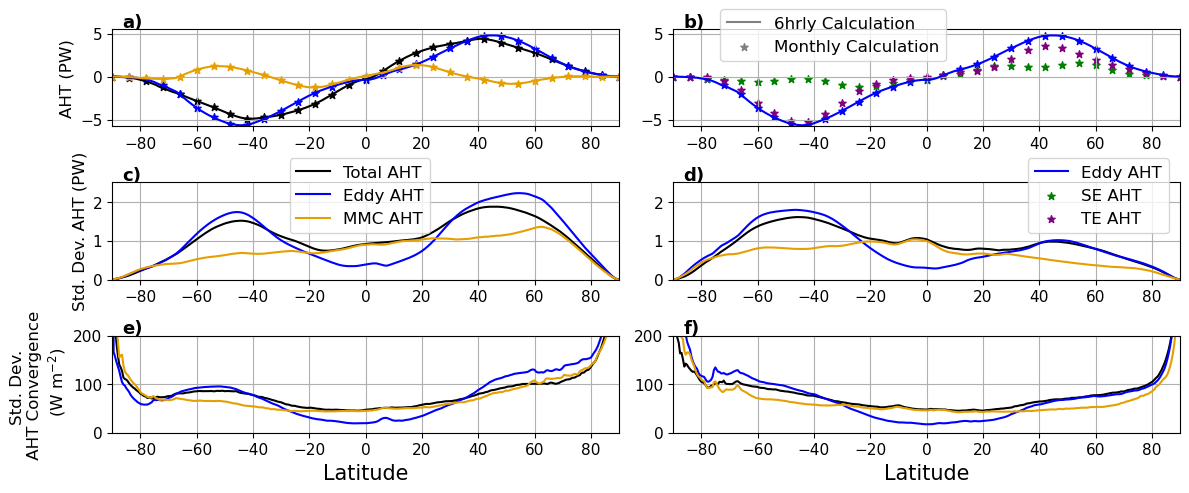

In [134]:
fig, axs = plt.subplots(ncols=2, nrows = 3, figsize=(12, 5))

nth_point = 12

axs[0,0].plot(lats, aht_ds_6hrly.total_aht.mean(['time'])/ 1e15, linestyle='-', color='k', label='Total AHT')
axs[0,0].plot(lats, aht_ds_6hrly.eddy_aht.mean(['time'])/ 1e15, color='b', label='Eddy AHT')
axs[0,0].plot(lats, aht_ds_6hrly.mmc_aht.mean(['time'])/ 1e15, color='#E69F00', label='MMC AHT')

#axs[0,0].plot(lats, aht_ds_monthly.total_aht.mean(['time']) / 1e15, '--', color='k')
#axs[0,0].plot(lats, (aht_ds_monthly.te_aht + aht_ds_monthly.se_aht).mean(['time']) / 1e15, '--', color='b')
#axs[0,0].plot(lats, aht_ds_monthly.mmc_aht.mean(['time']) / 1e15, '--', color='#E69F00')
axs[0,0].scatter(lats[::nth_point], aht_ds_monthly.total_aht.mean(['time'])[::nth_point] / 1e15, s=30, marker='*', color='k')
axs[0,0].scatter(lats[::nth_point], (aht_ds_monthly.te_aht + aht_ds_monthly.se_aht).mean(['time'])[::nth_point] / 1e15,
                 s=30, marker='*', color='b')
axs[0,0].scatter(lats[::nth_point], aht_ds_monthly.mmc_aht.mean(['time'])[::nth_point] / 1e15, s=30, marker='*', color='#E69F00')


axs[0,1].plot(lats, aht_ds_6hrly.eddy_aht.mean(['time'])/ 1e15, color='b', label='Eddy AHT')
axs[0,1].scatter(lats[::nth_point], (aht_ds_monthly.te_aht + aht_ds_monthly.se_aht).mean(['time'])[::nth_point] / 1e15,
                 s=30, marker='*', color='b')
axs[0,1].scatter(lats[::nth_point], aht_ds_monthly.se_aht.mean(['time'])[::nth_point] / 1e15,
                 s=30, marker='*', color='g', label='SE AHT')
axs[0,1].scatter(lats[::nth_point], aht_ds_monthly.te_aht.mean(['time'])[::nth_point] / 1e15,
                 s=30, marker='*', color='purple', label='TE AHT')
#axs[0,1].plot(lats, (aht_ds_monthly.te_aht + aht_ds_monthly.se_aht).mean(['time']) / 1e15, '--', color='b')
#axs[0,1].plot(lats, aht_ds_monthly.se_aht.mean(['time']) / 1e15, '--', color='g', label='SE AHT')
#axs[0,1].plot(lats, aht_ds_monthly.te_aht.mean(['time']) / 1e15, '--', color='purple', label='TE AHT')


axs[1,0].plot(lats, aht_6hrly_djf.total_aht.std('time') / 1e15, color='k')
axs[1,0].plot(lats, aht_6hrly_djf.eddy_aht.std('time') / 1e15, color='b')
axs[1,0].plot(lats, aht_6hrly_djf.mmc_aht.std('time') / 1e15, color='#E69F00')

axs[1,0].plot(lats + 500, aht_6hrly_djf.eddy_aht.std('time') / 1e15, color='grey',
              label='6hrly Calculation')
axs[1,0].scatter(lats + 500, aht_6hrly_djf.mmc_aht.std('time') / 1e15, s=30, marker='*',
                 color='grey', label='Monthly Calculation')

axs[1,1].plot(lats, aht_6hrly_jja.total_aht.std('time') / 1e15, color='k')
axs[1,1].plot(lats, aht_6hrly_jja.eddy_aht.std('time') / 1e15, color='b')
axs[1,1].plot(lats, aht_6hrly_jja.mmc_aht.std('time') / 1e15, color='#E69F00')

lat_circumf = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a
m_per_lat = 111000

axs[2,0].plot(lats, (aht_grad_djf.total_aht / lat_circumf / m_per_lat).std('time'), color='k')
axs[2,0].plot(lats, (aht_grad_djf.eddy_aht / lat_circumf / m_per_lat).std('time'), color='b')
axs[2,0].plot(lats, (aht_grad_djf.mmc_aht / lat_circumf / m_per_lat).std('time'), color='#E69F00')

axs[2,1].plot(lats, (aht_grad_jja.total_aht / lat_circumf / m_per_lat).std('time'), color='k')
axs[2,1].plot(lats, (aht_grad_jja.eddy_aht / lat_circumf / m_per_lat).std('time'), color='b')
axs[2,1].plot(lats, (aht_grad_jja.mmc_aht / lat_circumf / m_per_lat).std('time'), color='#E69F00')

axs[0,0].tick_params(axis='both', which='major', labelsize=11)
axs[0,1].tick_params(axis='both', which='major', labelsize=11)
axs[1,0].tick_params(axis='both', which='major', labelsize=11)
axs[1,1].tick_params(axis='both', which='major', labelsize=11)
axs[2,0].tick_params(axis='both', which='major', labelsize=11)
axs[2,1].tick_params(axis='both', which='major', labelsize=11)

axs[0,0].grid()
axs[0,1].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()

axs[0,0].set_xlim([-90, 90])
axs[0,1].set_xlim([-90, 90])
axs[1,0].set_xlim([-90, 90])
axs[1,1].set_xlim([-90, 90])
axs[2,0].set_xlim([-90, 90])
axs[2,1].set_xlim([-90, 90])

axs[0,0].set_ylim([-5.8, 5.5])
axs[0,1].set_ylim([-5.8, 5.5])
axs[1,0].set_ylim([0, 2.5])
axs[1,1].set_ylim([0, 2.5])
axs[2,0].set_ylim([0, 200])
axs[2,1].set_ylim([0, 200])

axs[0,0].text(x=0.02, y=1.02, s='a)', transform=axs[0,0].transAxes, fontsize=13, fontweight='bold')
axs[0,1].text(x=0.02, y=1.02, s='b)', transform=axs[0,1].transAxes, fontsize=13, fontweight='bold')
axs[1,0].text(x=0.02, y=1.02, s='c)', transform=axs[1,0].transAxes, fontsize=13, fontweight='bold')
axs[1,1].text(x=0.02, y=1.02, s='d)', transform=axs[1,1].transAxes, fontsize=13, fontweight='bold')
axs[2,0].text(x=0.02, y=1.02, s='e)', transform=axs[2,0].transAxes, fontsize=13, fontweight='bold')
axs[2,1].text(x=0.02, y=1.02, s='f)', transform=axs[2,1].transAxes, fontsize=13, fontweight='bold')

axs[0,0].set_ylabel('AHT (PW)', fontsize=12)
axs[1,0].set_ylabel('Std. Dev. AHT (PW)', fontsize=12)
axs[2,0].set_ylabel('Std. Dev. \n AHT Convergence \n (W m$^{-2}$)', fontsize=12)
axs[2,0].set_xlabel('Latitude', fontsize=15)
axs[2,1].set_xlabel('Latitude', fontsize=15)

fig.tight_layout()

axs[0,0].legend(loc=(0.35, -1.1), fontsize=12)
axs[0,1].legend(loc=(0.7, -1.1), fontsize=12)
axs[1,0].legend(loc=(1.2, 2.25), fontsize=12)
axs[0,0].set_zorder(4)
axs[0,1].set_zorder(2)
axs[1,0].set_zorder(3)

#fig.savefig('figures/monthly_6_hrly_aht_comp_w_aht_conv')

plt.show()

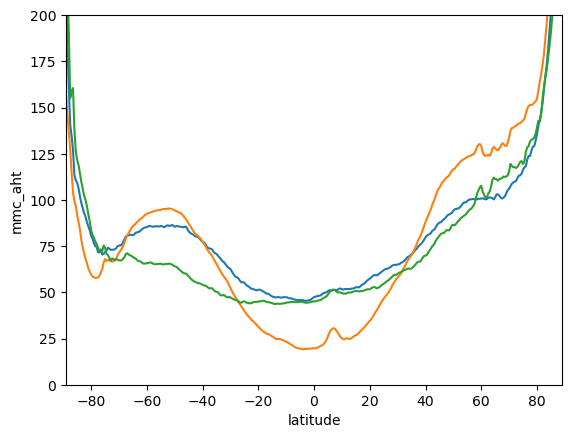

In [65]:
lat_circumf = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a

(aht_6hrly_djf.total_aht.differentiate('latitude') / 111000 / lat_circumf).std('time').plot()
(aht_6hrly_djf.eddy_aht.differentiate('latitude').std('time') / 111000 / lat_circumf).plot()
(aht_6hrly_djf.mmc_aht.differentiate('latitude').std('time') / 111000 / lat_circumf).plot()
plt.ylim([0, 200])
plt.xlim([-89, 89])
plt.show()

In [120]:
aht_6hrly_djf.eddy_aht.std('time').sel(latitude=50) / 1e15

<xarray.DataArray 'eddy_aht' ()>
array(2.18308449)
Coordinates:
    latitude  float64 50.0